# Can we predict the price of an item based on their description?

> **Is it possible to predict the price of an item based on the description?** <br>
> **How can we predict numerical values based on the text?**<br>

In the following analysis, we discuss more on these, and by the end of this analysis, we answer these questions with statistical evidence.

## Defining the Problem

The main objective of this analysis is to predict the price of an item by analyzing the product features, such as product description, brand, usage and category. This dataset collected from the [kagge](https://www.kaggle.com/). The raw data belong to **Mercari** business. Mercari business facilitates online portal where the consumers can sell their used items by uploading product image and respective product information. Mercari wants to provide an extra luxury feature to the consumers by predicting the price for an item based on their inputs. 

### Data Attributes

This dataset contains around 1.5 million observation with 8 features.
> - **train_id:** Id of the listing.
- **name:** Title of the listing. 
- **item_condition_id:** Condition of the items provided by the seller.
- **category_name:** Category of the listing.
- **brand_name:** Brand name of the product.
- **Shipping:** 1 if the seller pays and 0 if buyer pays the shipping fee by buyer.
- **item_description:** Full description of the item. 
- **price:** Price of the item.  Price is the target variable for this analysis. The unit of price is in USD. 

### Evaluation Metric
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The mathematical formula for RMSLE is


> ${\displaystyle \operatorname\epsilon  = \sqrt{{\frac {1}{n}}\sum _{i=1}^{n}(log(p_{i}+1)-log(a_{i}-1))^{2}}}$

Where:
- $ϵ$ is the RMSLE value (score)
- $n$ is the total number of observations in the (public/private) data set,
- $pi$ is your prediction of price, and
- $ai$ is the actual sale price for i. 
- $log(x)$ is the natural logarithm of x


## Discover Insights & Pre Processing

In this section, we explore more about data and prepare the data for model development. By stating that we are going to look at the underlying distribution of data, check for missing values and fix them if any. Apart from these, we also do some feature engineering before going into developing the model.

### Sanity check of data

In this section, we load the required libraries for this analysis into the environment. Read the data and perform a sanity check on the data. 

In [2]:
# import libraries
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from string import punctuation
from nltk.corpus import stopwords
import lightgbm as lgb
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
%matplotlib inline

/Users/anilkumar/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#  Reading the data into the python environment
train_df = pd.read_csv('/Users/anilkumar/Anils/DSDJ/portfolio/Draft/Mercari/Data/train.tsv', sep='\t')
test_df = pd.read_csv('/Users/anilkumar/Anils/DSDJ/portfolio/Draft/Mercari/Data/test_stg2.tsv', sep='\t')


In [4]:
# first few rows of train set
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
# first few rows of test set
test_df.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
# shape of trian and test set
train_df.shape, test_df.shape

((1482535, 8), (3460725, 7))

In [7]:
# feture types in train dataset
train_df.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [8]:
# feture types in train dataset
train_df['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [9]:
# quick stats on dataset
train_df.astype('object').describe()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1482535,1482535,1482535,1476208,849853,1482535.0,1482535,1482531
unique,1482535,1225273,5,1287,4809,828.0,2,1281426
top,1482534,Bundle,1,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,10.0,0,No description yet
freq,1,2232,640549,60177,54088,99416.0,819435,82489


The given dataset has **1,482,535** observations. Since we are predicting price, we separate this from the primary dataset and store it a **target_df** variable. Here onwards, we represent other variables as feature dataset.
When we look at the data type of each column, *item_condition_id* and *shipping treated* values are loaded as int; but when we look at the data, it is not true. These two values have encoded information of categorical value. Statistics of the feature dataset states the following information. <br>
- **train_id** feature has *1482535* unique values which are equal to the number of rows present in the dataset. This indicates that each row has a unique identifier. It may not be useful. There are no missing values as the number of rows are the same in dataset and feature.
- **name** feature has *1225273* unique values, top name is **bundle** and it appeared 2232 time in the dataset.
- **item_condition_id** have 5 unique values. Id *1* has the most number of occurrences that is *640549*. There are no missing values as the number of rows are the same in dataset and feature.
- **category_name** feature has *1287* unique values in it and *Women/Athletic Apparel/Pants, Tights, Leggings* appeared 60177 times in the current dataset. It looks like there are missing values in this feature. The number of rows for this feature is not matching the number of rows in the dataset.
- **brand_name** There are 4809 unique values in this feature. PINK is the most appeared brand in the dataset as it appears 54088 times. It looks like there are missing values in this feature. The number of rows for this feature is not matching the number of rows in the dataset.
- **shipping** This feature has only 2 unique values with 0 and 1.  0 is the most frequently appeared value in the dataset. As row count of this feature is equal to the number of rows in the dataset, we can pretend that there are no missing values in this feature.
- **item_description** There are *1281426* values and *'No description yet'* appeared *82489* times in the dataset. Since the row count is not matching, we can pretend that there are missing values in this feature.
- **price** This feature has *828* unique values and **10.00 USD** appeared *99416* times in the dataset. There are no missing values.

***Note: We discuss more on handling missing values in our further discussions.***

#### Critical insights after sanity check 

- Most of the products have price **$10.00 USD**.
- The top brand in the dataset is **PINK**.
- Most of the items in the dataset are related **women's stuff**.
- Majority of products come with **extra shipping cost**.


In [10]:
#  list out the numbr missing values in each feature
# train_df.isnull().sum()/len(train_df)*100
train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [11]:
test_df.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

The above table shows that brand_name has huge number of missing values ~43%. category_names feature is having ~0.4% missing values.

### Handeling Missing Values

There are only 3 features with missing values. brand_name has the highest missing values, so let's fill this feature's missing values with **unknown**. Let's fill the category_name feature also with **other** value. item_descripiton has only 4 missing values. These values can be filled with the highest frequency value **No description yet**.

In [12]:
# writing function to fill the missing values in the features
def handle_missing(df):
    df['brand_name'] = df['brand_name'].fillna(value='unknown').astype('str')
    df['category_name'] = df['category_name'].fillna(value='other').astype('str')  
    df['item_description'] = df['item_description'].fillna(value='No description yet').astype('str')
    df['shipping'] = df['shipping'].astype('str')
    df['item_condition_id'] = df['item_condition_id'].astype('str')
    

In [13]:
handle_missing(train_df)
handle_missing(test_df)

In [14]:
# just to check the imputed missing values reflecting in the dataset
print(train_df.isnull().sum())

print(f'Test data\n\n\n{test_df.isnull().sum()}')

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64
Test data


test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
dtype: int64


In [15]:
# Check for price values
len(train_df[train_df.price ==0])/len(train_df)*100

0.05895307699312327

There are **0.06%** of the observations in the dataset which has the price as ***$0.00 USD***. Since this is negligible, we will be removing these observations from feature dataset to reduce the noise in the model.

In [16]:
# get rid off 0 values items and then xhek the shape
train_df = train_df[train_df['price']>0].reset_index(drop=True)
train_df.shape, test_df.shape

((1481661, 8), (3460725, 7))

In [17]:
# Creating traget varible and number rows in training set
train_rows = train_df.shape[0]
target_df = np.log1p(train_df['price'])
train_rows, target_df.shape

(1481661, (1481661,))

Everything looks good. Let's do some Exploratory analysis on cleaned dataset.

### EDA

In this section, we will explore more about given features by plotting graphs.

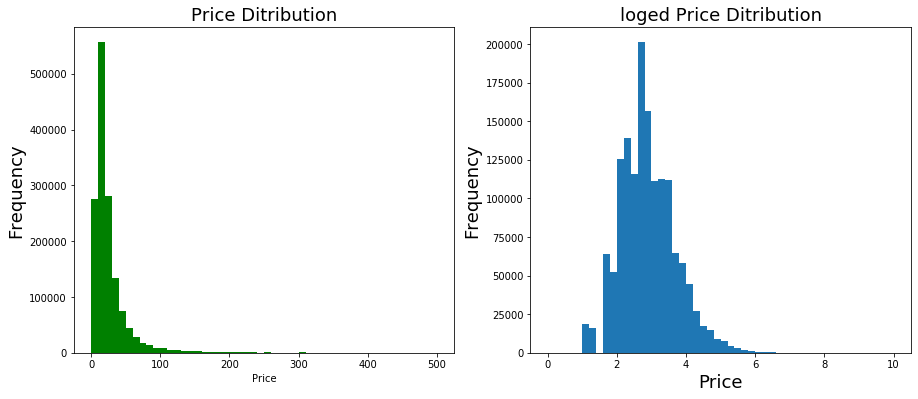

In [18]:
# Creating distribution plots of normal and log values of price 
plt.subplot(1,2,1)
train_df['price'].plot.hist(bins=50, figsize=(15, 6), range = [0,500], color='green')
plt.xlabel('Price')
plt.ylabel('Frequency', fontsize=18)
plt.title('Price Ditribution', fontsize=18)
plt.subplot(1,2,2)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('loged Price Ditribution', fontsize=18)
np.log(train_df['price']).plot.hist(bins=50, figsize=(15, 6), range = [0,10])

Target feature distribution has long right tail, when we look at the distribution of log price, values are lied around the $3.00 USD.

In [19]:
train_df['shipping'].value_counts(normalize=True)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

Shipping with '0' values represent shipping cost is bared by the buyer otherwise by seller. For 55% of the products, shipping cost is not included in the price. Shipping is free for 45% of the products. Let's see the relation between the shipping and the price.



In [20]:
# create separate df for free shipping nad no free shipping
free_shipping = train_df.loc[train_df['shipping']=='1', 'price']
No_free_shipping = train_df.loc[train_df['shipping']=='0', 'price']



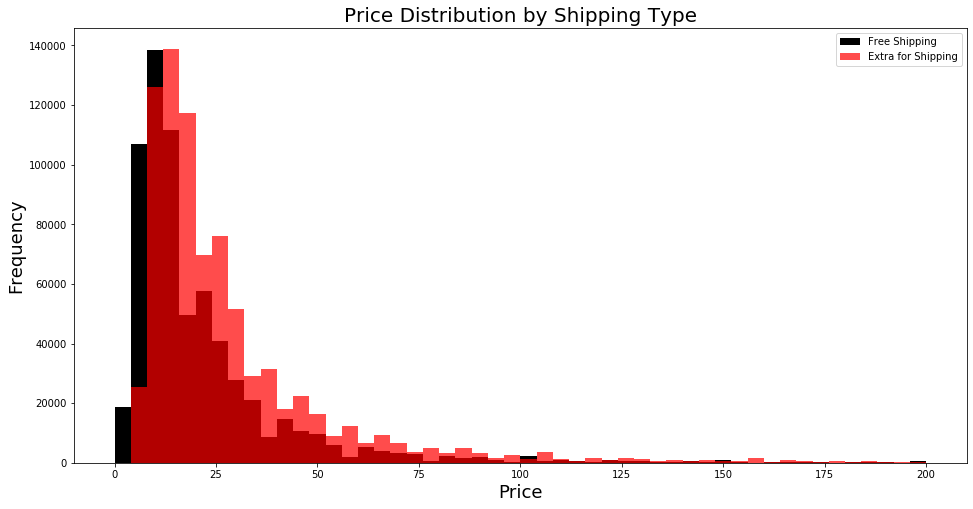

In [21]:
#  building plot to show the price distribution by the shipping category
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(free_shipping, color='black', alpha=1.0, bins=50, range = [0, 200],label='Free Shipping')
ax.hist(No_free_shipping, color='red', alpha=0.7, bins=50, range = [0, 200],label='Extra for Shipping')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Price Distribution by Shipping Type', fontsize=20)
plt.legend()


In [22]:
# lets see the average price for each shipping category
print(f'The average price for the products with shipping cost is ${round(np.mean(free_shipping), 2)} USD.')
print(f'The average price for the products without shipping cost is ${round(np.mean(No_free_shipping), 2)} USD.')
print(f'The median price for the products with shipping cost is ${round(np.median(free_shipping), 2)} USD.')
print(f'The median price for the products without shipping cost is ${round(np.median(No_free_shipping), 2)} USD.')

The average price for the products with shipping cost is $22.58 USD.
The average price for the products without shipping cost is $30.13 USD.
The median price for the products with shipping cost is $14.0 USD.
The median price for the products without shipping cost is $20.0 USD.


Suprisingly, average and median price for the products with free shipping is lower than teh products without free shipping.

In [23]:
# Top 10 categories
train_df['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Name: category_name, dtype: int64

Most of the `category_name` feature values are in three parts like *"Beauty/Makeup/Makeup Palettes"*. Let's split these into different categories.

Text(0.5, 1.0, 'Top 20 categories')

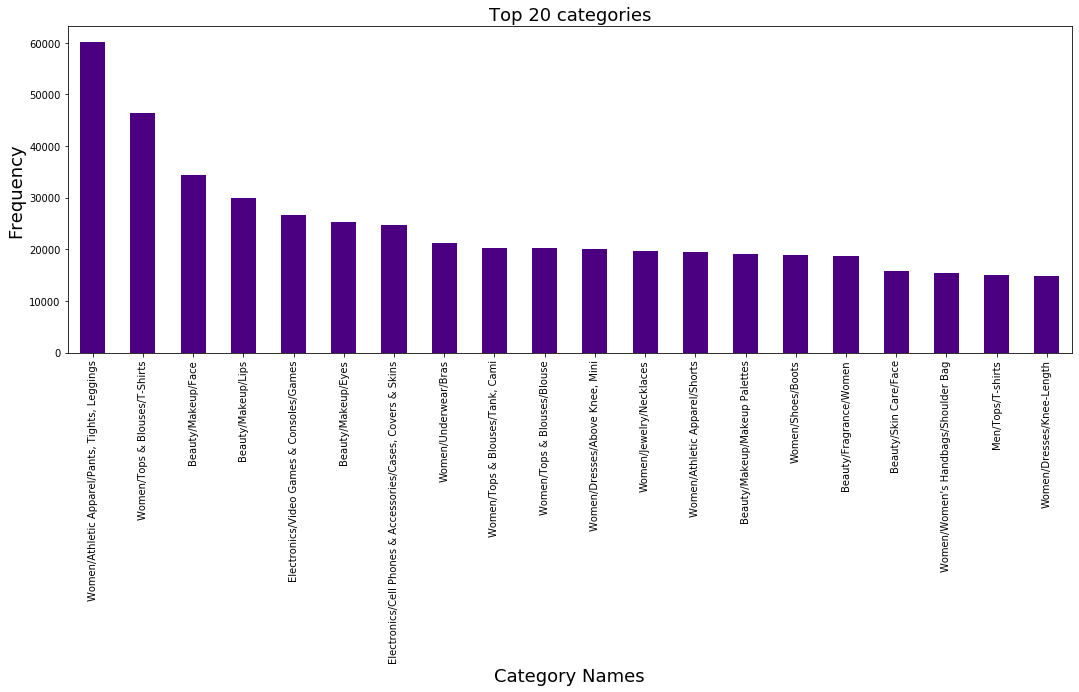

In [24]:
# Plotting top 20 categories
train_df['category_name'].value_counts()[:20].plot(kind='bar', figsize=(18,6), color='indigo')
plt.xlabel('Category Names', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Top 20 categories', fontsize=18)

Text(0.5, 1.0, 'Top 20 Brands')

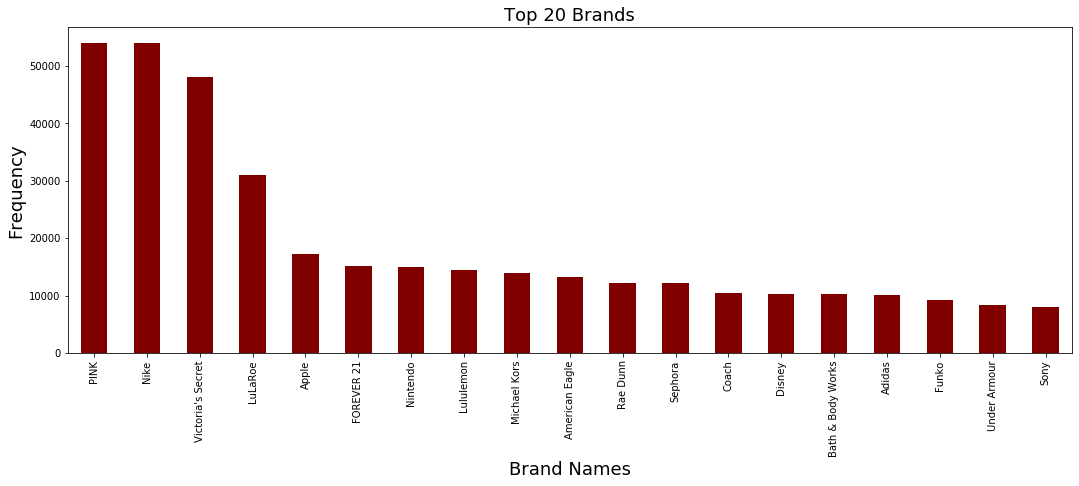

In [25]:
train_df['brand_name'].value_counts()[1:20].plot(kind='bar', figsize=(18,6), color='maroon')
plt.xlabel('Brand Names', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Top 20 Brands', fontsize=18)

***Note:*** *Since we set the product brand name to `unknown` where we don't have value for brand name in the feature, we are skipping that value while plotting.*

In [26]:
#  Number of brands with unknown
print(f'There are {len(train_df["brand_name"].value_counts())} brands available in the current dataset')
print(f'There are {sum(train_df["brand_name"].value_counts() == 1)} brands which have only one item for each brand')

There are 4808 brands available in the current dataset
There are 1241 brands which have only one item for each brand


In [27]:
# Function to split the column into three categories
def split_cat(col):
    try:
        Main_cat, Sub1_cat, Sub2_cat = col.split('/')
        return Main_cat, Sub1_cat, Sub2_cat
    except:
        return 'other', 'other', 'other'



In [28]:
# creating categories dataframe
categories = pd.DataFrame()
categories['cat_main'], categories['cat_sub1'], categories['cat_sub2'] = zip(*train_df['category_name'].apply(split_cat))
categories['price'] = train_df['price']
# categories.head()

In [29]:
categories['cat_main'].value_counts()

Women                     663990
Beauty                    207725
Kids                      171555
Electronics               119577
Men                        93292
Home                       67831
Vintage & Collectibles     46519
Other                      45329
Handmade                   30833
Sports & Outdoors          24311
other                      10699
Name: cat_main, dtype: int64

***Top categories are women and beauty.*** Let's plot and see.

Text(0.5, 0, 'Number of Items')

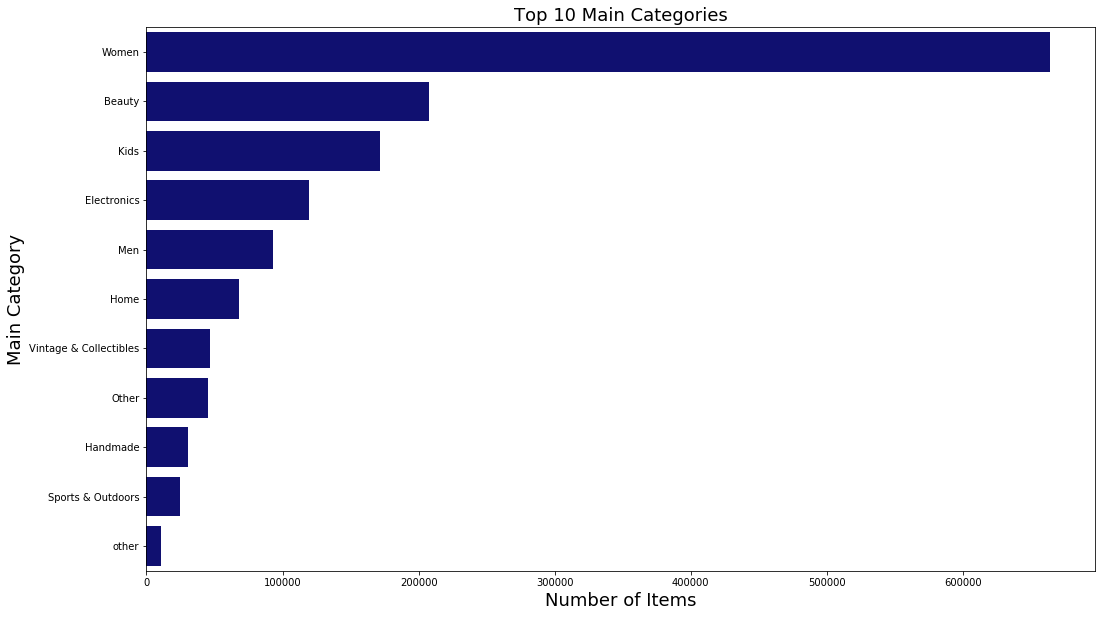

In [30]:
plt.figure(figsize=(17,10))
sns.countplot(y=categories['cat_main'], order=categories['cat_main'].value_counts().index, color='navy')
plt.title('Top 10 Main Categories', fontsize = 18)
plt.ylabel('Main Category', fontsize = 18)
plt.xlabel('Number of Items', fontsize = 18)

In [31]:
print(f'There are {len(categories["cat_main"].value_counts())} main categories, {len(categories["cat_sub1"].value_counts())} sub category 1 and {len(categories["cat_sub2"].value_counts())} sub category 2 items in the given dataset.')

There are 11 main categories, 114 sub category 1 and 865 sub category 2 items in the given dataset.


### Feature engineering 1 &  Text Processing

- When we look at the **name** and **brand_name** feature values, most of the time, brand name is present in the name. So, let's create name by concatenating these together. 
- Other than **shipping** and **item condiiton id** other features are in text format, so we will create a document for a row by concatening all other text features. 

In [32]:
def text_process(df):
    df1 = pd.DataFrame()
    df1['con_name'] = df['name']+ ' ' + df['brand_name']
    df1['text'] = df['item_description'] + ' ' + df['name'] + ' ' + df['category_name']  
    df1['shipping'] = df['shipping']
    df1['item_condition_id'] = df['item_condition_id']
    return df1

In [33]:
# craete new features for train, test set and merge train & test so that it will be easier to perform vectorizing the words
f1 = text_process(train_df)
f2 = text_process(test_df)
feature = pd.concat([f1, f2])
f1.shape, f2.shape, feature.shape

((1481661, 4), (3460725, 4), (4942386, 4))

In [34]:
# function to remove the punctuation
def rmv_pun(sent):
    return sent.translate(str.maketrans('','', punctuation))


# Removing punctuations
feature['con_name'] = feature['con_name'].apply(rmv_pun)
feature['text'] = feature['text'].apply(rmv_pun)

In [35]:
# vectorizing the concatanated name column
tv_n = TfidfVectorizer(max_features=100000, token_pattern='\w+')
X_name = tv_n.fit_transform(feature['con_name'])

# vectorizing the text column
tv_t=TfidfVectorizer(max_features=100000, token_pattern='\w+', ngram_range=(1,3))
X_text = tv_t.fit_transform(feature['text'])

# create dummies for shipping item condistion features
X_dummies = csr_matrix(pd.get_dummies(feature[['item_condition_id', 'shipping']], sparse=True).values)


X_dummies.shape, X_name.shape, X_text.shape

((4942386, 7), (4942386, 100000), (4942386, 100000))

In [36]:
#  stack the spare matrix horizantally
feature_df = hstack((X_name, X_text,X_dummies)).tocsr()

### Feature engineering 2

Let's keep all the features as it is and combine the train and test features. Later perform all the mentioned tasks on combined dataset.

In [37]:
tr = train_df.copy()
te = test_df.copy()

In [38]:
main_df = pd.concat([tr, te])
sub2 = pd.DataFrame()
sub2 = test_df[['test_id']]

In [39]:
# import gc
# gc.collect()

In [40]:
# vectorizing the name column
cv = CountVectorizer()
X_name = cv.fit_transform(main_df['name'])


# vectorizing the category name column
cv = CountVectorizer()
X_cat = cv.fit_transform(main_df['category_name'])


# vectorizing the item decription column
tv = TfidfVectorizer(max_features=100000, ngram_range=(1,3))
X_desc = tv.fit_transform(main_df['item_description'])


# binarizing all the brand names
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(main_df['brand_name'])


# create dummies for shipping item condistion features
X_dummies = csr_matrix(pd.get_dummies(main_df[['item_condition_id', 'shipping']],sparse=True).values)

In [41]:
# creating sparse matrix
sparse_main = hstack((X_dummies, X_desc, X_brand, X_cat, X_name)).tocsr()

In [43]:
# %time new_trns_train = tfvectorizer.fit_transform(train_df.values)

## Developing

***When I tried Ridge, Lasso, XGBoost, Random Forest, Linear Regression and LighGBM algorithms with 3 or 5 folds CV,  lightGBM gave the best results. The plan is to use ensemble weighted model with lightGBM and Ridge algorithms. The weights for lightGBM and Ridge are 60, 40 respectively. I have tried few random combination of weights, 60:40 ratio gave the best results for the developed model.***

Developing the model based on feature engineering - 1.

In [44]:
# Splitting the data into train and test based on actual dataset

train_var = feature_df[:train_rows]
test_var = feature_df[train_rows:]

In [45]:
# Define the lightgbmdataset
train_data = lgb.Dataset(train_var, label=target_df)
params={'learning_rate':0.75,
       'application':'regression',
       'max_depth': 200,
       'verbosity': 5,
       'metric':'RMSE'}

In [46]:
model = lgb.train(params, train_set=train_data, num_boost_round=3200, verbose_eval=100) 
preds_lgb = 0.60*model.predict(test_var)

In [47]:
model = Ridge(solver='sag', fit_intercept=True, random_state=201)
model.fit(train_var, target_df)
preds_lgb += 0.4*model.predict(test_var)



In [48]:
subm = pd.DataFrame()
subm = test_df[['test_id']]

In [49]:
subm['price'] = np.expm1(preds_lgb)
subm.to_csv('lgbm_ridge_mercari.csv', index=False)

Developing the model based on feature engineering - 2.

In [50]:
train_data = sparse_main[:train_rows]
test_data = sparse_main[train_rows:]


In [51]:
d_t = lgb.Dataset(train_data, label=target_df)

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

model = lgb.train(params, train_set=d_t, num_boost_round=3200, verbose_eval=100) 
preds = 0.57*model.predict(test_data)



In [52]:
model = Ridge(solver="sag", fit_intercept=True, random_state=205)
model.fit(train_data, target_df)
preds += 0.43*model.predict(test_data)


In [53]:
sub2['price'] = np.expm1(preds)
sub2.to_csv('lgbm_ridge_mercari_f2.csv', index=False)

## Deploying

Since the data is collected from the kaggle, we can just export our model into a CSV file which can be used for the future look-up. Another way of deploying this model is by creating an API, which can take requests and spit-out the predictions.

## Final thoughts

In this analysis, we have used TFIDF for the text features and count vectorizer for other features. I ran these models on MacOS with the configuration of 40GB RAM, 4.2 GHz Intel Core i7. It took around 39 Mins to train the model with LightGBM algorithm and 58 Mins with ridge algorithm.

There is scope for improvement. Below are my thoughts for further improvements 
- Train using neural nets
- Run on GPU cluster
- More feature engineering(concatenating various columns)

In this notebook,  I have used analytical style approach where we can build the model in bits and pieces while exploring and analyzing the data. We can also write the production-ready codebase by creating classes and building pipelines.